# MODFLOW 6 : Unconfined Steady-State Flow Model

This tutorial demonstrates use of FloPy to develop a simple MODFLOW 6 model.

First we load the packages.

In [28]:
import os
import numpy as np
import matplotlib.pyplot as plt
import flopy

We are creating a square model with a specified head equal to h1 along all boundaries. The head at the cell in the center in the top layer is fixed to h2. First, set the name of the model and the parameters of the model: the number of layers Nlay, the number of rows and columns N, lengths of the sides of the model L, aquifer thickness H, hydraulic conductivity k.

In [29]:
name = "Model00"
h1 = 100
h2 = 90
Nlay = 10
N = 101
L = 400.0
H = 50.0
k = 1.0

Create the Flopy Model Objects
One big difference between MODFLOW 6 and previous MODFLOW versions is that MODFLOW 6 is based on the concept of a simulation. A simulation consists of the following:

- Temporal discretization (TDIS)
- One or more models
- Zero or more exchanges (instructions for how models are coupled)
- Solutions

For this simple example, the simulation consists of the temporal discretization (TDIS) package, a groundwater flow (GWF) model, and an iterative model solution (IMS), which controls how the GWF model is solved.

In [30]:
sim = flopy.mf6.MFSimulation(sim_name=name, exe_name="mf6", version="mf6", sim_ws=".")

In [31]:
tdis = flopy.mf6.ModflowTdis(sim, pname="tdis", time_units="DAYS", nper=1, perioddata=[(1.0, 1, 1.0)])

## IMS

Create the Flopy IMS Package object

In [32]:
ims = flopy.mf6.ModflowIms(sim, pname="ims", complexity="SIMPLE")

## GWF

Create the Flopy groundwater flow (gwf) model object

In [33]:
model_nam_file = "{}.nam".format(name)
gwf = flopy.mf6.ModflowGwf(sim, modelname=name, model_nam_file=model_nam_file)

## Building the model

Now that the overall simulation is set up, we can focus on building the groundwater flow model. The groundwater flow model will be built by adding packages to it that describe the model characteristics.

## DIS

Create the discretization (DIS) Package and define the discretization of the model. All layers are given equal thickness. The bot array is build from H and the Nlay values to indicate top and bottom of each layer, and delrow and delcol are computed from model size L and number of cells N. Once these are all computed, the Discretization file is built.

In [34]:
bot = np.linspace(-H / Nlay, -H, Nlay)
delrow = delcol = L / (N - 1)
dis = flopy.mf6.ModflowGwfdis(
    gwf,
    nlay=Nlay,
    nrow=N,
    ncol=N,
    delr=delrow,
    delc=delcol,
    top=0.0,
    botm=bot,
)

## Initial conditions

Create the initial conditions (IC) Package

In [36]:
start = h1 * np.ones((Nlay, N, N))
ic = flopy.mf6.ModflowGwfic(gwf, pname="ic", strt=start)

## Node property flow 

Create the node property flow (NPF) Package

In [38]:
npf = flopy.mf6.ModflowGwfnpf(gwf, icelltype=1, k=k, save_flows=True)

## Constant head

Create the constant head (CHD) Package and list information is created a bit differently for MODFLOW 6 than for other MODFLOW versions. The cellid (layer, row, column, for a regular grid) can be entered as a tuple as the first entry. Remember that these must be zero-based indices!

In [39]:
chd_rec = []
chd_rec.append(((0, int(N / 4), int(N / 4)), h2))
for layer in range(0, Nlay):
    for row_col in range(0, N):
        chd_rec.append(((layer, row_col, 0), h1))
        chd_rec.append(((layer, row_col, N - 1), h1))
        if row_col != 0 and row_col != N - 1:
            chd_rec.append(((layer, 0, row_col), h1))
            chd_rec.append(((layer, N - 1, row_col), h1))
chd = flopy.mf6.ModflowGwfchd(
    gwf,
    maxbound=len(chd_rec),
    stress_period_data=chd_rec,
    save_flows=True,
)

The CHD Package stored the constant heads in a structured array, also called a numpy.recarray. We can get a pointer to the recarray for the first stress period (iper = 0) as follows.

In [41]:
iper = 0
ra = chd.stress_period_data.get_data(key=iper)
ra

rec.array([((0, 25, 25),  90.), ((0, 0, 0), 100.), ((0, 0, 100), 100.),
           ..., ((9, 100, 99), 100.), ((9, 100, 0), 100.),
           ((9, 100, 100), 100.)],
          dtype=[('cellid', 'O'), ('head', '<f8')])

## Output

In [42]:
# Create the output control (`OC`) Package
headfile = "{}.hds".format(name)
head_filerecord = [headfile]
budgetfile = "{}.cbb".format(name)
budget_filerecord = [budgetfile]
saverecord = [("HEAD", "ALL"), ("BUDGET", "ALL")]
printrecord = [("HEAD", "LAST")]
oc = flopy.mf6.ModflowGwfoc(
    gwf,
    saverecord=saverecord,
    head_filerecord=head_filerecord,
    budget_filerecord=budget_filerecord,
    printrecord=printrecord,
)

## Run

In [43]:
sim.write_simulation()


writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims...
  writing model Model00...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package chd_0...
    writing package oc...


In [45]:
success, buff = sim.run_simulation()
if not success:
    raise Exception("MODFLOW 6 did not terminate normally.")

FloPy is using the following executable to run the model: AppData\Local\flopy\bin\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.4.2 06/28/2023

   MODFLOW 6 compiled Jul 05 2023 20:31:54 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Go

## Plotting

<a list of 6 text.Text objects>

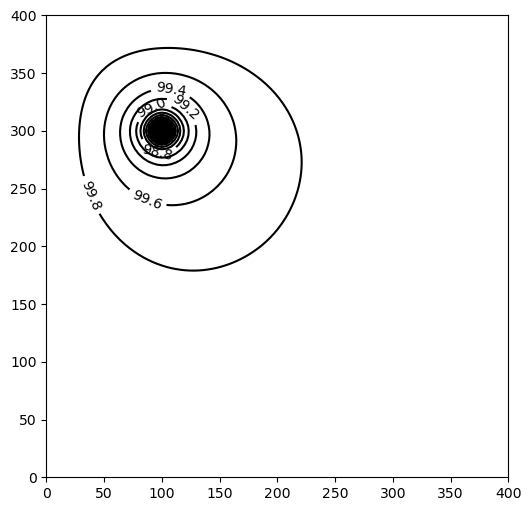

In [46]:
hds = flopy.utils.binaryfile.HeadFile(headfile)
h = hds.get_data(kstpkper=(0, 0))
x = y = np.linspace(0, L, N)
y = y[::-1]
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
c = ax.contour(x, y, h[0], np.arange(90, 100.1, 0.2), colors="black")
plt.clabel(c, fmt="%2.1f")

## Cross-section

<a list of 2 text.Text objects>

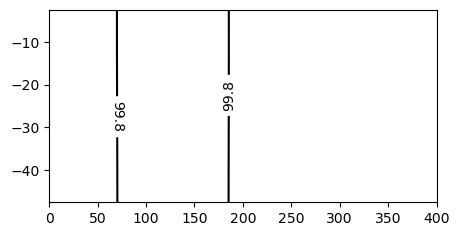

In [47]:
z = np.linspace(-H / Nlay / 2, -H + H / Nlay / 2, Nlay)
fig = plt.figure(figsize=(5, 2.5))
ax = fig.add_subplot(1, 1, 1, aspect="auto")
c = ax.contour(x, z, h[:, 50, :], np.arange(90, 100.1, 0.2), colors="black")
plt.clabel(c, fmt="%1.1f")